In [35]:
import os
import sys
import random 

import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from functools import partial
import matplotlib.pyplot as plt 

sys.path.append("..")

from IPython import display

# %load_ext autoreload
# %autoreload 2

## Download datasets

In [12]:
mnist = torchvision.datasets.MNIST("../datasets", train=True, download=True)
cifar10 = torchvision.datasets.CIFAR10("../datasets", download=True)
cifar100 = torchvision.datasets.CIFAR100("../datasets", download=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

## Test

In [62]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

trainset = CIFAR10(root='../datasets', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = CIFAR10(root='../datasets', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

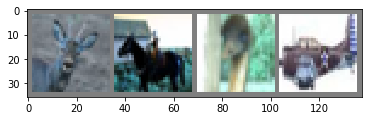

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, target = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))